In [17]:
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.utils import shuffle
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Let's compare the effectivity of the PCA

# Load data
data_file_path = '../dataset/secom.data'
labels_file_path = '../dataset/secom_labels.data'

data_raw = pd.read_csv(data_file_path, sep='\s+', header=None)
labels = pd.read_csv(labels_file_path, sep='\s+', header=None, usecols=[0], names=['Label'])
print("Labels before:\n")
print(labels)
labels = labels.replace(1, 0)  # Change 1 to 0, fail = 0
labels = labels.replace(-1, 1)  # Change -1 to 1, pass = 1
print("\n Labels after: \n")
print(labels)

Labels before:

      Label
0        -1
1        -1
2         1
3        -1
4        -1
...     ...
1562     -1
1563     -1
1564     -1
1565     -1
1566     -1

[1567 rows x 1 columns]

 Labels after: 

      Label
0         1
1         1
2         0
3         1
4         1
...     ...
1562      1
1563      1
1564      1
1565      1
1566      1

[1567 rows x 1 columns]


In [3]:
# Combine features and labels into a single DataFrame
data = pd.concat([data_raw, labels], axis=1)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1


In [4]:
# Separate data by class
data_class_0 = data[data['Label'] == 0].drop('Label', axis=1)
data_class_1 = data[data['Label'] == 1].drop('Label', axis=1)

print("Class 0 data: \n")
print(data_class_0.head())

print("\n Class 1 data: \n")
print(data_class_1.head())


Class 0 data: 

        0        1          2          3       4      5         6       7    \
2   2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
10  2994.05  2548.21  2195.1222  1046.1468  1.3204  100.0  103.3400  0.1223   
11  2928.84  2479.40  2196.2111  1605.7578  0.9959  100.0   97.9156  0.1257   
14  2963.97  2629.48  2224.6222   947.7739  1.2924  100.0  104.8489  0.1197   
23  2884.74  2514.54  2160.3667   899.9488  1.4022  100.0  105.4978  0.1240   

       8       9    ...     580       581     582     583     584     585  \
2   1.4436  0.0041  ...  0.0148   82.8602  0.4958  0.0157  0.0039  3.1745   
10  1.5144 -0.0190  ...  0.0071   57.8122  0.4925  0.0158  0.0041  3.2115   
11  1.4690  0.0170  ...  0.0081   75.5077  0.4987  0.0427  0.0092  8.5646   
14  1.4474  0.0144  ...  0.0084  142.9080  0.5077  0.0094  0.0026  1.8483   
23  1.5585 -0.0317  ...  0.0077  216.8869  0.4982  0.0099  0.0027  1.9771   

       586     587     588       589  
2   0.0

In [5]:
# Impute missing values for each class separately
imputer = SimpleImputer(strategy='mean')

# Impute class 0
data_class_0_imputed = imputer.fit_transform(data_class_0)
data_class_0_imputed = pd.DataFrame(data_class_0_imputed, columns=data_class_0.columns)
data_class_0_imputed['Label'] = 0  # Add the label column back

# Impute class 1
data_class_1_imputed = imputer.fit_transform(data_class_1)
data_class_1_imputed = pd.DataFrame(data_class_1_imputed, columns=data_class_1.columns)
data_class_1_imputed['Label'] = 1

In [6]:
# Combine the imputed data back together
data_imputed = pd.concat([data_class_0_imputed, data_class_1_imputed], axis=0)

print("Combined data before shuffle: \n")
print(data_imputed)

# Shuffle the data then reset the index
data_imputed = shuffle(data_imputed)
data_imputed = data_imputed.reset_index(drop=True)

print("\n \n Combined data after shuffle: \n")
print(data_imputed)

Combined data before shuffle: 

            0        1          2          3       4      5         6       7  \
0     2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
1     2994.05  2548.21  2195.1222  1046.1468  1.3204  100.0  103.3400  0.1223   
2     2928.84  2479.40  2196.2111  1605.7578  0.9959  100.0   97.9156  0.1257   
3     2963.97  2629.48  2224.6222   947.7739  1.2924  100.0  104.8489  0.1197   
4     2884.74  2514.54  2160.3667   899.9488  1.4022  100.0  105.4978  0.1240   
...       ...      ...        ...        ...     ...    ...       ...     ...   
1458  2899.41  2464.36  2179.7333  3085.3781  1.4843  100.0   82.2467  0.1248   
1459  3052.31  2522.55  2198.5667  1124.6595  0.8763  100.0   98.4689  0.1205   
1460  2978.81  2379.78  2206.3000  1110.4967  0.8236  100.0   99.4122  0.1208   
1461  2894.92  2532.01  2177.0333  1183.7287  1.5726  100.0   98.7978  0.1213   
1462  2944.92  2450.76  2195.4444  2914.1792  1.5978  100.0   85.1011  0.1235

In [7]:
# Separate data and labels
labels_imputed = data_imputed['Label']
data_imputed = data_imputed.drop('Label', axis=1)

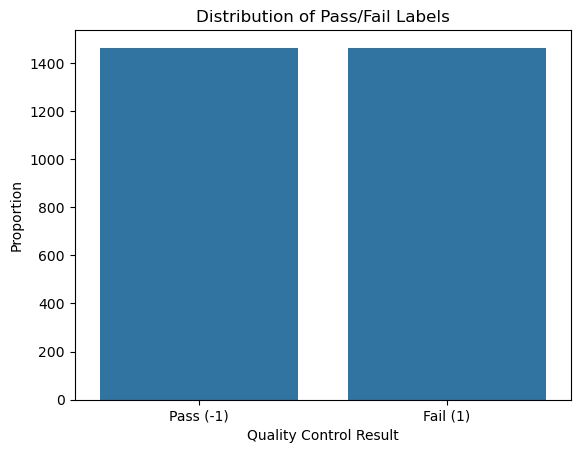

In [18]:
# Handle class imbalance with oversampling using SMOTE (Synthetic Minority Over-sampling Technique)

smote = SMOTE(random_state=42)
data_smoted, labels_smoted = smote.fit_resample(data_imputed, labels_imputed)

target_distribution = labels_smoted.value_counts()

sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title("Distribution of Pass/Fail Labels")
plt.ylabel("Proportion")
plt.xlabel("Quality Control Result")
plt.xticks(ticks=[0, 1], labels=["Pass (-1)", "Fail (1)"])
plt.show()

In [13]:
# Save to csv file
with open('../dataset/secom_data_smoted.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(data_smoted), file)

with open('../dataset/secom_labels_smoted.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(labels_smoted), file)